# Titanic - Machine Learning from Disaster (Kaggle competition )

In this project, we're going to explore a workflow to make competing in the [Kaggle Titanic competition](https://www.kaggle.com/c/titanic/data) easier using a pipeline of functions. 

The [data page for the Titanic competitions on Kaggle](https://www.kaggle.com/c/titanic/data) also has a data dictionary, which explains the various columns that make up the data set. Below are the descriptions contained in that data dictionary:

- PassengerID - A column added by Kaggle to identify each row and make submissions easier
- Survived - Whether the passenger survived or not and the value we are predicting (0=No, 1=Yes)
- Pclass - The class of the ticket the passenger purchased (1=1st, 2=2nd, 3=3rd)
- Sex - The passenger's sex
- Age - The passenger's age in years
- SibSp - The number of siblings or spouses the passenger had aboard the Titanic
- Parch - The number of parents or children the passenger had aboard the Titanic
- Ticket - The passenger's ticket number
- Fare - The fare the passenger paid
- Cabin - The passenger's cabin number
- Embarked - The port where the passenger embarked (C=Cherbourg, Q=Queenstown, S=Southampton)

The Kaggle workflow we are going to build will combine all of the following steps into a process.

<img src='kaggle_workflow.svg' width='500px'>

- **Data exploration**, to find patterns in the data
- **Feature engineering**, to create new features from those patterns or through pure experimentation
- **Feature selection**, to select the best subset of our current set of features
- **Model selection/tuning**, training a number of models with different hyperparameters to find the best performer.

In [1]:
import pandas as pd
pd.options.display.max_columns=30
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')
holdout.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


load the functions.py we wrote previously to Jupyter Notebook using the syntax

*%load [filename]*

for example

%load functions.py

Note that once we run that cell, the contents from the functions.py file would be copied into the cell. If we ran the cell one more time, the code would run, giving us the output of funtions.py if it has any.

In [2]:
# %load functions.py
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins'

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins'

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins'

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    # A pattern with one group will return a DataFrame with one column if expand=True.
    # A pattern with one group will return a Series if expand=False.
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df


In [3]:
def pre_process(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    
    for col in ["Age_categories", "Fare_categories","Title", "Cabin_type", "Sex"]:
        df = create_dummies(df,col)
        
    return df

train = pre_process(train)
holdout = pre_process(holdout)

# Exploring the data

In this first stage, we're going to examine the two columns that contain information about the family members each passenger had onboard: SibSp and Parch.

- SibSp - The number of siblings or spouses the passenger had aboard the Titanic
- Parch - The number of parents or children the passenger had aboard the Titanic

In [4]:
explore = train[['SibSp', 'Parch', 'Survived']].copy()
explore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 3 columns):
SibSp       891 non-null int64
Parch       891 non-null int64
Survived    891 non-null int64
dtypes: int64(3)
memory usage: 21.0 KB


In [5]:
explore['SibSp'].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [6]:
explore['Parch'].value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

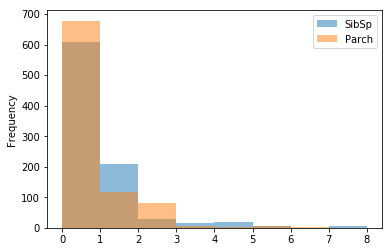

In [7]:
explore.drop('Survived', axis=1).plot.hist(alpha=0.5, bins=8)
plt.show()

In [8]:
explore['familysize'] = explore[['SibSp', 'Parch']].sum(axis=1)
explore['familysize'].value_counts()

0     537
1     161
2     102
3      29
5      22
4      15
6      12
10      7
7       6
Name: familysize, dtype: int64

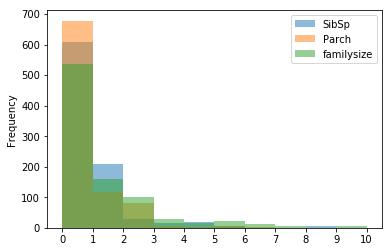

In [9]:
explore.drop('Survived', axis=1).plot.hist(alpha=0.5, bins=10)
plt.xticks(range(11))
plt.show()

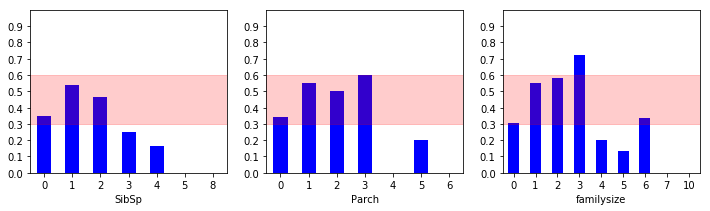

In [10]:
fig, ax = plt.subplots(1,3, figsize=(12,3))
n = 0
for col in explore.columns.drop('Survived'):
    explore.groupby(col).mean()['Survived'].plot.bar(ax=ax[n], color='blue', rot=0)
    ax[n].set_yticks(np.arange(0, 1, .1))
    ax[n].set_ylim((0,1))
    ax[n].axhspan(.3, .6, alpha=0.2, color='red')
    n += 1    

plt.show()


The SibSp column shows the number of siblings and/or spouses each passenger had on board, while the Parch columns shows the number of parents or children each passenger had onboard. Neither column has any missing values.

The distribution of values in both columns is skewed right, with the majority of values being zero.

We summed these two columns to explore the total number of family members each passenger had onboard. The shape of the distribution of values in this case is similar, however there are less values at zero, and the quantity tapers off less rapidly as the values increase.

Looking at the survival rates of the the combined family members, weu can see that few of the over 500 passengers (over 30%) with no family members survived, while greater numbers of passengers with family members survived.

In [11]:
print(explore.shape)
explore.groupby('familysize').agg(['count','sum','mean'])['Survived']

(891, 4)


,count,sum,mean
familysize,,,
0,537,163,0.303538
1,161,89,0.552795
2,102,59,0.578431
3,29,21,0.724138
4,15,3,0.200000
5,22,3,0.136364
6,12,4,0.333333
7,6,0,0.000000
10,7,0,0.000000


# Engineering new features

From the previous step we can see that by combining the values of SibSp and Parch into a single column, only 30% of the passengers who had no family members onboard survived.

Based of this, we can come up with an idea for a new feature - was the passenger alone. This will be a binary column containing the value:

- 1 if the passenger has zero family members onboard
- 0 if the passenger has one or more family members onboard

In [12]:
def process_isalone(df):
    df['familysize'] = df[['SibSp', 'Parch']].sum(axis=1)    
    df.loc[df['familysize'] == 0, 'isalone'] = 1
    df.loc[df['familysize'] >= 1, 'isalone'] = 0
    df.drop('familysize', axis=1, inplace=True)
    return df

train = process_isalone(train)
holdout = process_isalone(holdout)

# Selecting the best performing features

We will use  scikit-learn's [feature_selection.RFECV](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html)(Recursive feature elimination with cross-validation) class to automate selecting the best-performing features using recursive feature elimination.

As for the etimator, we will use Random Forests for now.

In [13]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

def select_features(df):
    
    numeric_df = df.select_dtypes(include=[np.number]).dropna(axis=1)
    
    all_X = numeric_df.drop(['Survived','PassengerId'], axis=1)
    all_y = numeric_df['Survived']
    
    rf = RandomForestClassifier(random_state=1)
    selector = RFECV(rf, step=1, cv=10)
    selector.fit(all_X, all_y)
    
    best_columns = list(all_X.columns[selector.support_])
    
    return best_columns

selected_features = select_features(train)
selected_features

['Pclass',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Age_categories_Missing',
 'Age_categories_Infant',
 'Age_categories_Young Adult',
 'Fare_categories_12-50',
 'Title_Miss',
 'Title_Mr',
 'Title_Mrs',
 'Cabin_type_D',
 'Cabin_type_E',
 'Cabin_type_Unknown',
 'Sex_female',
 'Sex_male',
 'isalone']

# Selecting and tunning different algorithms

Now we are going to write a function to do the heavy lifting of model selection and tuning. The function we'll create will use three different algorithms and use grid search to train using different combinations of hyperparameters to find the best performing model.

We can achieve this by creating a list of dictionaries— that is, a list where each element of the list is a dictionary. Each dictionary should contain:

- The name of the particular model
- An estimator object for the model
- A dictionary of hyperparameters that we'll use for grid search.

We can then use a for loop to iterate over the list of dictionaries, and for each one we can use scikit-learn's [model_selection.GridSearchCV class](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to find the best set of performing parameters, and add values for both the parameter set and the score to the dictionary.

Finally, we can return the list of dictionaries, which will have our trained GridSearchCV objects as well as the results so we can see which was the most accurate.

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

def select_model(df, features):
    
    all_X = df[features]
    all_y = df['Survived']
    
    models = [{
                    "name": "LogisticRegression",
                    "estimator": LogisticRegression(),                    
                    "hyperparameters":
                        {
                            "solver": ["newton-cg", "lbfgs", "liblinear"]
                        }
                },
        {
                    "name": "KNeighborsClassifier",
                    "estimator": KNeighborsClassifier(),
                    "hyperparameters":
                        {
                            "n_neighbors": range(1,20,2),
                            "weights": ["distance", "uniform"],
                            "algorithm": ["ball_tree", "kd_tree", "brute"],
                            "p": [1,2]
                        }
                },
                {
                    "name": "RandomForestClassifier",
                    "estimator": RandomForestClassifier(),
                    "hyperparameters":
                        {
                            "n_estimators": [4, 6, 9],
                            "criterion": ["entropy", "gini"],
                            "max_depth": [2, 5, 10],
                            "max_features": ["log2", "sqrt"],
                            "min_samples_leaf": [1, 5, 8],
                            "min_samples_split": [2, 3, 5]
                        }
                }
    ]
    
    for model in models:
        print(model['name'])
        print('-'*len(model['name']))
        clf = GridSearchCV(model['estimator'], model['hyperparameters'], cv=10)
        clf.fit(all_X, all_y)
        
        model['best_params'] = clf.best_params_
        model['best_score'] = clf.best_score_
        model['best_model'] = clf.best_estimator_
        
        print('Best score: {}'.format(model['best_score']))
        print('Best parameters: {}\n'.format(model['best_params']))
        
    return models
        
result = select_model(train, selected_features)

LogisticRegression
------------------
Best score: 0.8204264870931538
Best parameters: {'solver': 'liblinear'}

KNeighborsClassifier
--------------------
Best score: 0.7755331088664422
Best parameters: {'algorithm': 'brute', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}

RandomForestClassifier
----------------------
Best score: 0.8361391694725028
Best parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 3, 'n_estimators': 9}



# Making a submission to Kaggle

After running the above function, we have three scores from three different models. At this point in the workflow, we have a decision to make: Do we want to train our best model on the holdout set and make a Kaggle submission, or do we want to go back to engineering features.

When adding a feature to our model doesn't improve the accuracy. In this case we should go back to data exploration and repeat the cycle again. But here, we are going to want to train our best model on the holdout set and make a Kaggle submission

In [ ]:
def save_submission_file(test, model, features, filename='submission.csv'):
    
    houdout_data = test[features]
    predictions = model.predict(holdout_data)
    
    holdout_ids = holdout['PassengerId']
    submisstion_df = {'PassengerId': holdout_ids,
                     'Survived': predictions}
    submission = pd.DataFrame(submission_df)
    
    submisstion.to_csv(filename, index=False)
    
best_rf_model = result[2]['best_model']
save_submission_file(best_rf_model, selected_features)

# Next steps

Next we can:

- Continue to explore the data and create new features, following the workflow and using the functions we created.
- Read more about the titanic and this Kaggle competition to get ideas for new features.
- Use some different algorithms in the select_model() function, like [support vector machines](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html), [stochastic gradient descent](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) or [perceptron](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html) linear models.
- Experiment with RandomizedSearchCV instead of GridSearchCV to speed up the select_features() function.